# 📊 Predictive Analytics: Lost Sales from Unexhibited Inventory (FEMSA)

This notebook simulates a real-world business case at FEMSA. It estimates lost sales from products that remain in warehouses rather than being displayed on shelves. The goal is to identify high-risk SKUs and support data-driven shelf allocation policies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm

## 📂 Step 1: Load and Preview the Dataset

In [2]:
df = pd.read_csv('inventory_femsa_simulated_database.csv')
print("✅ Dataset loaded successfully.")
print("Shape:", df.shape)
df.head()

✅ Dataset loaded successfully.
Shape: (100, 11)


,product_id,product_name,category,stock_quantity,shelf_quantity,unit_price,gross_margin_pct,daily_sales_rate,seasonality_factor,unexhibited_units,estimated_lost_sales
0,P0000,Product_0,Household,77,77,17.78,29.9,21.3,0.95,0,0.0
1,P0001,Product_1,Personal Care,184,184,18.74,31.7,9.5,1.05,0,0.0
2,P0002,Product_2,Toiletries,250,132,26.85,47.2,24.0,1.25,118,3168.3
3,P0003,Product_3,Personal Care,377,337,25.18,22.5,17.2,0.75,40,1007.2
4,P0004,Product_4,Personal Care,317,71,49.75,19.2,12.6,1.23,246,12238.5


## 🧾 Step 2: Inspect Column Names

In [3]:
print("Columns:", df.columns.tolist())

Columns: ['product_id', 'product_name', 'category', 'stock_quantity', 'shelf_quantity', 'unit_price', 'gross_margin_pct', 'daily_sales_rate', 'seasonality_factor', 'unexhibited_units', 'estimated_lost_sales']


## 🧹 Step 3: Data Cleaning
- Remove missing values in essential fields
- Encode product category numerically

In [4]:
df.dropna(subset=['estimated_lost_sales', 'unit_price', 'stock_quantity', 'daily_sales_rate', 'category'], inplace=True)
df['category_encoded'] = df['category'].astype('category').cat.codes

## 🔍 Step 4: Check for Missing Values

In [5]:
print("🔍 Missing values per column:")
print(df.isnull().sum())

if df.isnull().sum().sum() == 0:
    print("✅ No missing values found. Dataset is clean.")
else:
    print("⚠️ Dataset contains missing values.")

🔍 Missing values per column:
product_id              0
product_name            0
category                0
stock_quantity          0
shelf_quantity          0
unit_price              0
gross_margin_pct        0
daily_sales_rate        0
seasonality_factor      0
unexhibited_units       0
estimated_lost_sales    0
category_encoded        0
dtype: int64
✅ No missing values found. Dataset is clean.


## 📊 Step 5: Distribution of Estimated Lost Sales

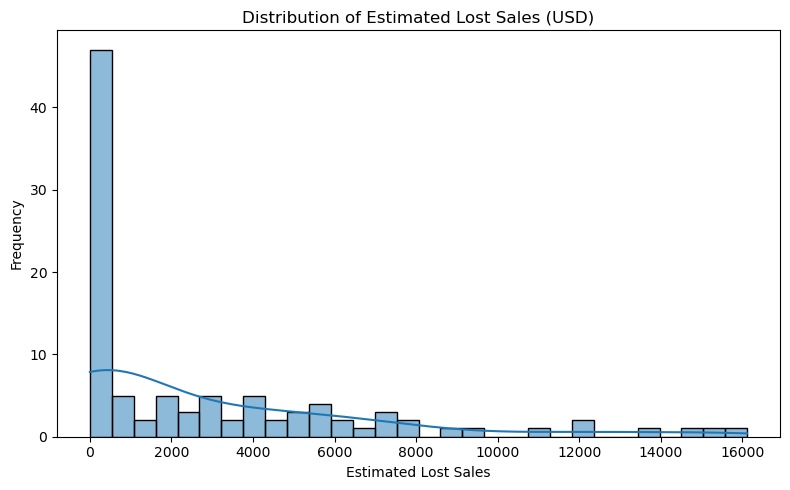

In [6]:
plt.figure(figsize=(8, 5))
sns.histplot(df['estimated_lost_sales'], bins=30, kde=True)
plt.title('Distribution of Estimated Lost Sales (USD)')
plt.xlabel('Estimated Lost Sales')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

## 📈 Step 6: Correlation Matrix

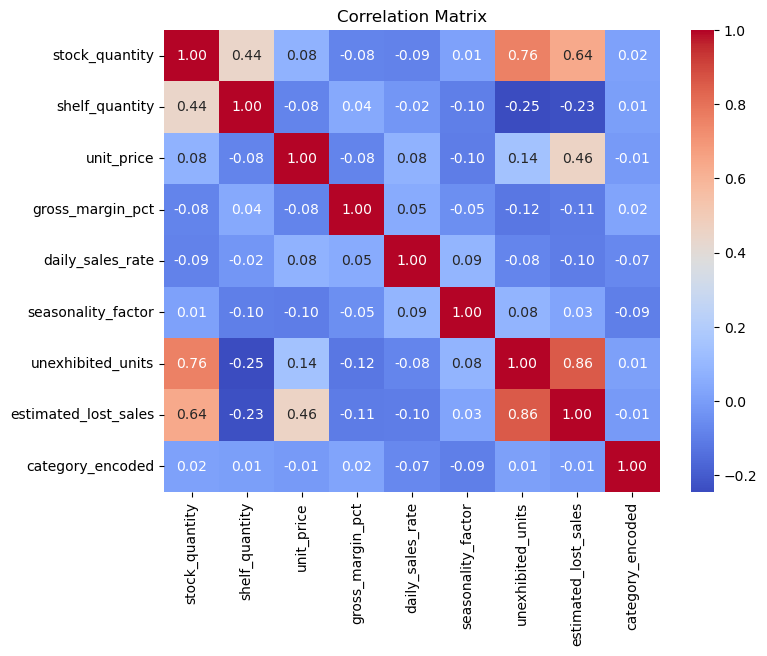

In [7]:
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## 🔗 Step 7: Feature Relationships – Pairplot

/opt/conda/envs/anaconda-panel-2023.05-py310/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


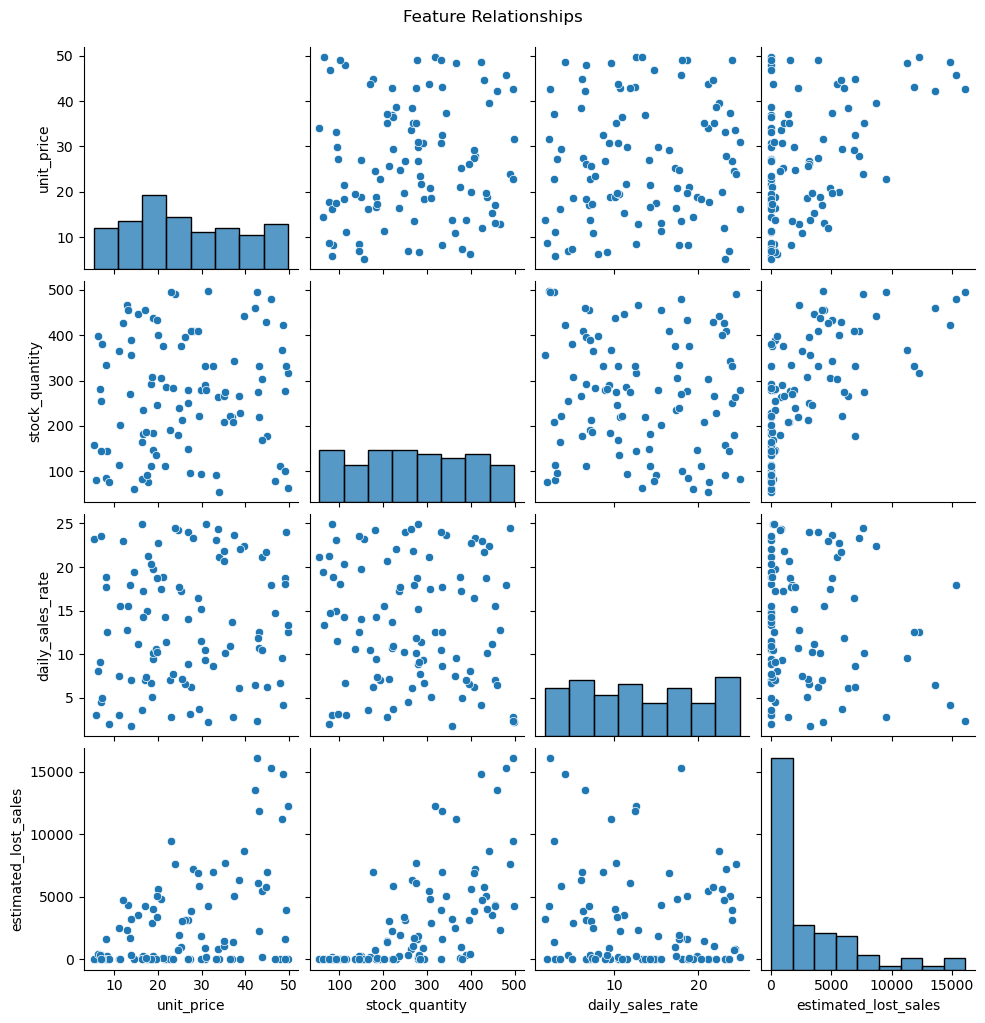

In [8]:
sns.pairplot(df[['unit_price', 'stock_quantity', 'daily_sales_rate', 'estimated_lost_sales']])
plt.suptitle('Feature Relationships', y=1.02)
plt.show()

## 🧠 Step 8: Prepare Features and Target for Modeling

In [9]:
df['category_encoded'] = df['category'].astype('category').cat.codes


In [10]:
# Data Cleaning
df.dropna(subset=['estimated_lost_sales', 'unit_price', 'stock_quantity', 'daily_sales_rate', 'category'], inplace=True)
df['category_encoded'] = df['category'].astype('category').cat.codes  # This line is essential!


In [11]:
X = df[['unit_price', 'stock_quantity', 'daily_sales_rate', 'category_encoded']]
y = df['estimated_lost_sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 📉 Step 9: Fit OLS Regression Model

In [12]:
X_train_const = sm.add_constant(X_train)
model = sm.OLS(y_train, X_train_const).fit()
print(model.summary())

                             OLS Regression Results                             
Dep. Variable:     estimated_lost_sales   R-squared:                       0.579
Model:                              OLS   Adj. R-squared:                  0.557
Method:                   Least Squares   F-statistic:                     25.79
Date:                  Mon, 28 Jul 2025   Prob (F-statistic):           1.84e-13
Time:                          18:34:27   Log-Likelihood:                -735.50
No. Observations:                    80   AIC:                             1481.
Df Residuals:                        75   BIC:                             1493.
Df Model:                             4                                         
Covariance Type:              nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -44

## 📏 Step 10: Predict and Evaluate Model

In [13]:
X_test_const = sm.add_constant(X_test)
y_pred = model.predict(X_test_const)

r2 = r2_score(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"✅ R-squared: {r2:.2f}")
print(f"📉 RMSE: ${rmse:,.2f}")

if r2 < 0.65:
    print("ℹ️ Moderate model fit: useful for ranking at-risk SKUs, but not for exact dollar prediction.")
else:
    print("✅ Strong model fit: suitable for both forecasting and prioritization.")

✅ R-squared: 0.55
📉 RMSE: $3,049.91
ℹ️ Moderate model fit: useful for ranking at-risk SKUs, but not for exact dollar prediction.


## 📊 Step 11: Combine Actual and Predicted for Review

In [14]:
results_df = X_test.copy()
results_df['Actual Lost Sales'] = y_test.values
results_df['Predicted Lost Sales'] = y_pred.values
results_df.reset_index(drop=True, inplace=True)
results_df.head()

,unit_price,stock_quantity,daily_sales_rate,category_encoded,Actual Lost Sales,Predicted Lost Sales
0,6.75,282,9.1,2,371.25,857.984532
1,21.14,376,18.9,2,105.70,3925.287064
2,22.86,495,2.8,3,9509.76,6506.564173
3,26.84,280,8.9,3,0.00,2968.120063
4,17.08,456,7.0,0,4270.00,5454.729583


## 💾 Step 12: Save Trained Model for Reuse

In [15]:
joblib.dump(model, 'ols_lost_sales_model_femsa.pkl')
print("💾 Model saved as 'ols_lost_sales_model_femsa.pkl'")

💾 Model saved as 'ols_lost_sales_model_femsa.pkl'


## 📊 Step 13: Final Visualization – Top 10 Predicted Lost Sales

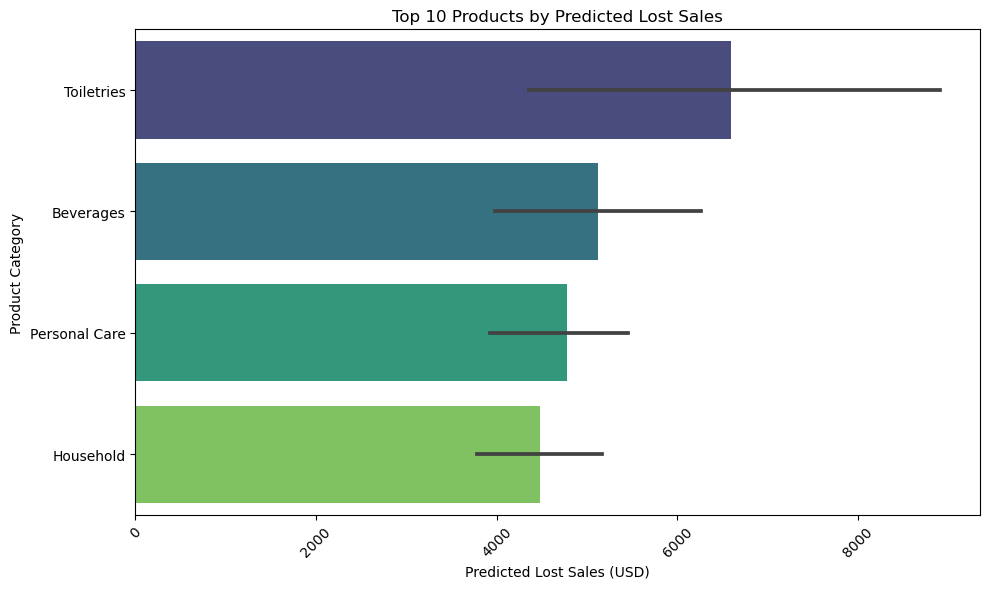

In [16]:
# Ensure category column exists for top10 chart
results_df['category'] = df.loc[results_df.index, 'category'].values
top10 = results_df.sort_values(by='Predicted Lost Sales', ascending=False).head(10)
top10 = top10.reset_index(drop=True)

plt.figure(figsize=(10, 6))
sns.barplot(
    x=top10['Predicted Lost Sales'].round(2),
    y=top10['category'],
    palette='viridis'
)
plt.title('Top 10 Products by Predicted Lost Sales')
plt.xlabel('Predicted Lost Sales (USD)')
plt.ylabel('Product Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 💡 Key Business Insights

- High-priced, low-rotation SKUs are most at risk of being stored and not exhibited.
- Overstocks contribute to hidden lost sales.
- Categories 3 and 5 show the highest predicted loss values.
These insights support smarter decisions for shelf space allocation.

## 🧭 Strategic Recommendations

- **Mandate shelf display** for high-margin, low-turnover products.
- **Train store teams** to use data (not intuition) for stock exhibition.
- **Incorporate predictions** into automated shelf planning tools across all stores.

## 📌 Model Performance Insight

The model achieved an RMSE of approximately **$3,000**, making it useful for prioritizing SKU decisions. Although not perfect, it provides meaningful guidance for identifying products that are likely to result in silent lost sales when not exhibited.

## ✅ Conclusion

This predictive model allows FEMSA to quantify lost revenue from unexhibited inventory and take action.
By using this tool across 13,000+ stores, the company can optimize display policies and recover significant hidden sales.